# ROOT LOCUS ANALYSIS

One approach to designing a closed loop system is to design the controller so as to achieve desired poles of the closed loop for the following objectives:
* stability
* short settling times
* no oscillations

A root locus plot shows the relationship between a controller parameter, its open loop poles and zeroes, and its closed loop poles.

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install control
    !pip -q install tellurium

In [13]:
import collections
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
tf = k1*k2/(s*(s+k2))

In [6]:
def evaluateTransferFunction(model, transfer_function, input_name, output_name, times=TIMES,
                             is_plot=True, figsize=(5,5), title="", **kwargs):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony or roadrunner
        tranfer_function (control.TransferFunction)
        input_name: (str)
        output_name: (str) prediction
        times: (np.darray)
        kwargs: simultion parameters
    Returns:
        float
    """
    if isinstance(model, str):
        rr = te.loada(model)
    else:
        rr = model
    for key, value in kwargs.items():
        rr[key] = value
    rr.reset()
    data = rr.simulate(times[0], times[-1], len(times))
    new_output_name = "[" + output_name + "]"
    if new_output_name in data.colnames:
        output_name = new_output_name
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    predictions = rr[input_name]*predictions
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        ax.plot([0, maxval], [0, maxval], color="red")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        ax.set_title(title)
    return rmse

rmse = evaluateTransferFunction(TEST_MODEL, tf, "S1", "S3", k1=1, figsize=(3,3), is_plot=False)
assert(rmse < 1e-5)
print("OK!")

OK!


In [7]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model. 

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       ExtendedRoadrunner
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = float(value)
    if selections is None:
        rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return rr

# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
print("OK!")

OK!


In [22]:
Parameters = collections.namedtuple("Parameters", "k1 k2 k3 S1 kP kI, setpoint")
def getParameters(model=MODEL1):
    """
    Retrieves constants used in the open and closed loop models.
    
    Args:
        model: str/Roadrunner
        
    Returns:
        Parameters
    """
    def get(name):
        if name in rr.keys():
            return rr[name]
        return 0
    #
    if isinstance(model, str):
        rr = te.loada(model)
    else:
        rr = model
    #
    parameters = Parameters(
        k1=get("k1"),
        k2=get("k2"),
        k3=get("k3"),
        setpoint=get("setpoint"),
        kP=get("kP"),
        kI=get("kI"),
        S1=get("S1"),
    )
    return parameters

# Tests
parameters = getParameters()
assert(isinstance(parameters, Parameters))
print("OK!")
    

OK!


In [75]:
def plotPoles(model=MODEL1, kPs=0, kIs=0, xlim=None, is_plot=True):
    """
    Plots the open loop poles and zeroes and closed loop poles for the model.
    
    Args:
        model: antimony or roadrunner
        kPs: list/float
        kIs: list/float
        xlim: tuple (limits of x-axis on plot)
    """
    p = getParameters(model=model)
    if isinstance(kPs, int) or isinstance(kPs, float):
        kPs = [kPs]
    if isinstance(kIs, int) or isinstance(kIs, float):
        kIs = [kIs]
    if len(kPs) == 1:
        kPs = np.repeat(kPs[0], len(kIs))
    if len(kIs) == 1:
        kIs = np.repeat(kIs[0], len(kPs))
    #
    annotations = []
    ppoles = []
    npoles = []
    zeroes = []
    for kI in kIs:
        for kP in kPs:
            ol_tf = p.k1*p.k2/((s + p.k2)*(s+ p.k3))
            C_tf = kP + kI/s
            cl_tf = control.feedback(ol_tf*C_tf)
            closed_poles = cl_tf.poles()
            if len(closed_poles) > 0:
                annotations.append("%2.2f, %2.2f" % (kP, kI))
                ppoles.append(closed_poles[0])
                npoles.append(closed_poles[1])
    poles = list(ppoles)
    poles.extend(npoles)
    zeroes = np.array(zeroes)
    annotations.extend(annotations)
    poles = np.array(poles)
    if is_plot:
        _, ax = plt.subplots(1)
        ax.scatter(poles.real, poles.imag, marker="*", c="blue")
        ol_poles = ol_tf.poles()
        ax.scatter(ol_poles.real, ol_poles.imag, marker="o", c="red")
        _ = [ax.annotate(t, (p.real, p.imag), fontsize=8) for t, p in zip(annotations, poles)]
        ax.set_xlabel("real")
        ax.set_ylabel("imag")
        _ = ax.set_title("Open and closed loop poles for kP, kI.")
        if xlim is not None:
            ax.set_xlim(xlim)
    
# Tests
plotPoles(kPs=[0.01, 0.1, 10, 100], is_plot=False)
print("OK!")

OK!


# Relating Poles and Zeroes of the Open Loop System (OLS) to the Closed Loop System

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/simple_feedback_nofilter.png/
     width="600">

Let $C(s)$ be the transfer function of the controller and $G(s)$ be the transfer function of the OLS.
Then, the transfer function of the closed loop is:
\begin{eqnarray}
H(s) & = & \frac{ C(s)G(s)}{1 +C(s) G(s)} \\
\end{eqnarray}

Let $G(s) = \frac{Z(s)}{P(s)}$.
\begin{eqnarray}
H(s) & = & \frac{ C(s)\frac{Z(s)}{P(s)}}{1 +C(s)\frac{Z(s)}{P(s)}} \\
& = & \frac{C(s) Z(s)}{P(s) + C(s) Z(s)} \\
\end{eqnarray}

## Analyis of a chemical network

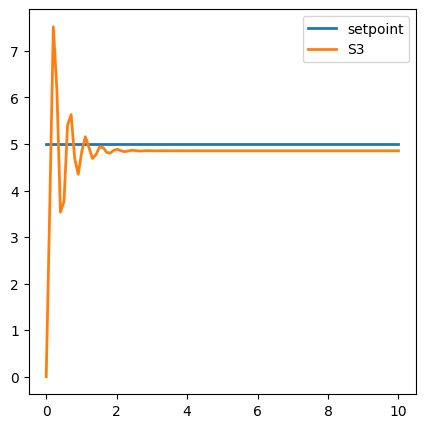

In [8]:
MODEL1 = """
// Open loop system
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S2 = 0
k1 =1
k2 = 2
k3 = 3
// Feedback constants
setpoint = 1  # Input to the closed loop is the setpoint or reference
kP = 1  # Design parameter for P controller
// Feedback loop
control_error := setpoint - S3
$S1 := kP*control_error   # Controller implementation
"""
SETPOINT = 5
rr =plotModel(MODEL1, setpoint=SETPOINT, kP=100, selections=["setpoint", "S3"])

**Transfer Functions**

* Open loop transfer function $G(s) = \frac{k_1 k_2}{(s + k_2)(s + k_3)}$.
* Open loop zeroes: $s = ??$
* Open loop poles $s = ??$

Now let's see how the closed loop poles change as we change $k_P$.

Let $C(s) = k_P$. Then, $$H(s) = \frac{k_P Z(s)}{P(s) + k_P Z(s)}$$.

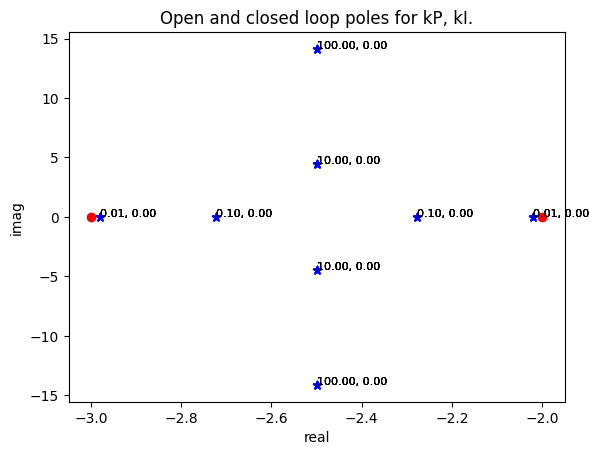

In [64]:
plotPoles(kPs=[0.01, 0.1, 10, 100])

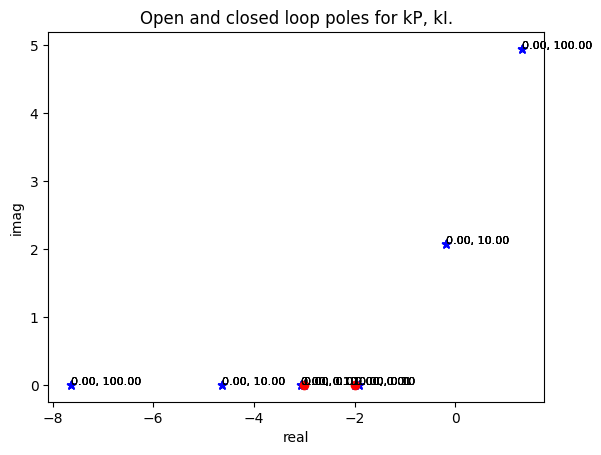

In [76]:
plotPoles(kIs=[0.01, 0.1, 10, 100])

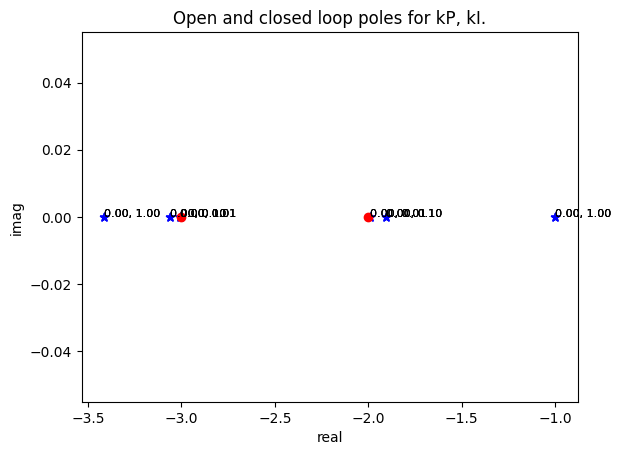

In [77]:
plotPoles(kIs=[0.01, 0.1, 1])